In [1]:
# Found at:
# https://medium.com/towards-data-science/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## The Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [3]:
data = pd.read_parquet('data/2_featured/tripfeatures.parquet')
data.columns = [col.lower().replace('_', ' ') for col in data.columns]
print(data.shape)
print(list(data.columns))

(23573264, 9)
['is subscriber', 'gender', 'tripduration in h', 'start dow', 'start month', 'start hour', 'customer age', 'trip distance in km', 'trip speed kmh']


In [4]:
data.head()

,is subscriber,gender,tripduration in h,start dow,start month,start hour,customer age,trip distance in km,trip speed kmh
0,Subscriber,Male,0.049167,6 Saturday,09 September,22,36,0.338241,6.879438
1,Subscriber,Male,0.117778,6 Saturday,09 September,22,28,1.020775,8.666940
2,Subscriber,Male,0.077778,6 Saturday,09 September,22,32,0.820588,10.550392
3,Subscriber,Male,0.070556,6 Saturday,09 September,22,42,0.540759,7.664255
4,Subscriber,Male,0.077222,6 Saturday,09 September,22,23,0.530870,6.874599


### Create dummy variables from Categorial ones

In [5]:
cat_vars=['gender', 'start dow', 'start hour', 'start month']
for var in cat_vars:
    category_df = pd.get_dummies(data[var], prefix=var)
    category_df.columns = [col.lower().replace('_', ': ') for col in category_df]
    data = pd.concat([data,category_df] , axis=1)

# drop labeled categories
data = data.drop(cat_vars, axis=1)
data.head()

,is subscriber,tripduration in h,customer age,trip distance in km,trip speed kmh,gender: female,gender: male,gender: unknown,start dow: 0 sunday,start dow: 1 monday,...,start month: 03 march,start month: 04 april,start month: 05 may,start month: 06 june,start month: 07 july,start month: 08 august,start month: 09 september,start month: 10 october,start month: 11 november,start month: 12 december
0,Subscriber,0.049167,36,0.338241,6.879438,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Subscriber,0.117778,28,1.020775,8.666940,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Subscriber,0.077778,32,0.820588,10.550392,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Subscriber,0.070556,42,0.540759,7.664255,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Subscriber,0.077222,23,0.530870,6.874599,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
# Remove base categories
data = data.drop('gender: male', axis=1) # set males as base category
data = data.drop('start dow: 0 sunday', axis=1) # set sunday as base category
data = data.drop('start hour: 8', axis=1) # set eight as base category
data = data.drop('start month: 05 may', axis=1) # set eight as base category

### Over-sampling using SMOTE

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# extract exogenous and endogenous variables
X = data.loc[:, data.columns != 'is subscriber']
y = data.loc[:, data.columns == 'is subscriber']

y = (y["is subscriber"] == 'Subscriber').astype(np.uint8)

# fix some dtypes for regression
X["tripduration in h"] = X["tripduration in h"].copy().astype('int64')
X["customer age"] = X["customer age"].copy().astype('int64')
X["trip distance in km"] = X["trip distance in km"].copy().astype('int64')


Xt, Xtt, yt, ytt = train_test_split(X, y, test_size = 0.05, random_state = 0)
yt, ytt = yt.astype('int'), ytt.astype('int')

columns = X.columns

print(f"""Counts before under-sampling:
\tN Training Rows: {len(Xt)}
\tN Test Rows: {len(Xtt)}

\tN Training Subscriber: {len(yt[yt==1])}
\tN Training Customer:   {len(yt[yt==0])}
""")
      
os = RandomUnderSampler(random_state=0, sampling_strategy=1.0)
Xt, yt = os.fit_resample(Xt, yt)

print(f"""Counts after under-sampling:
\tN Training Rows: {len(Xt)}
\tN Test Rows: {len(Xtt)}

\tN Training Subscriber: {len(yt[yt==1])}
\tN Training Customer:   {len(yt[yt==0])}
""")

/var/folders/g1/nhrjlfln17gcld3sg2f59mk80000gn/T/ipykernel_34153/3289267157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["tripduration in h"] = X["tripduration in h"].copy().astype('int64')
/var/folders/g1/nhrjlfln17gcld3sg2f59mk80000gn/T/ipykernel_34153/3289267157.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["customer age"] = X["customer age"].copy().astype('int64')
/var/folders/g1/nhrjlfln17gcld3sg2f59mk80000gn/T/ipykernel_34153/3289267157.py:13: SettingWithCopyWarning: 
A value is try

Counts before under-sampling:
	N Training Rows: 22394600
	N Test Rows: 1178664

	N Training Subscriber: 20054989
	N Training Customer:   2339611

Counts after under-sampling:
	N Training Rows: 4679222
	N Test Rows: 1178664

	N Training Subscriber: 2339611
	N Training Customer:   2339611



### Implementing the model

In [8]:
# drop intermediate dataframe and arrays
del data
del X
del y

In [9]:
import statsmodels.api as sm
from copy import deepcopy

# add constants.
Xt = sm.add_constant(Xt)
Xtt = sm.add_constant(Xtt)

# copute logistic regression
logit_mod = sm.Logit(yt, Xt)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.312126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          is subscriber   No. Observations:              4679222
Model:                          Logit   Df Residuals:                  4679175
Method:                           MLE   Df Model:                           46
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.5497
Time:                        21:23:51   Log-Likelihood:            -1.4605e+06
converged:                       True   LL-Null:                   -3.2434e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -2.6137      0.011   -231.111      0.000      -2.

### Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
yhat_prob = logit_res.predict(Xtt)
yhat = np.round(yhat_prob).astype(int)
confusion_matrix = confusion_matrix(ytt, yhat)
print(confusion_matrix)

[[101830  20646]
 [108335 947853]]


In [11]:
from sklearn.metrics import classification_report
print(classification_report(ytt, yhat))

              precision    recall  f1-score   support

           0       0.48      0.83      0.61    122476
           1       0.98      0.90      0.94   1056188

    accuracy                           0.89   1178664
   macro avg       0.73      0.86      0.77   1178664
weighted avg       0.93      0.89      0.90   1178664



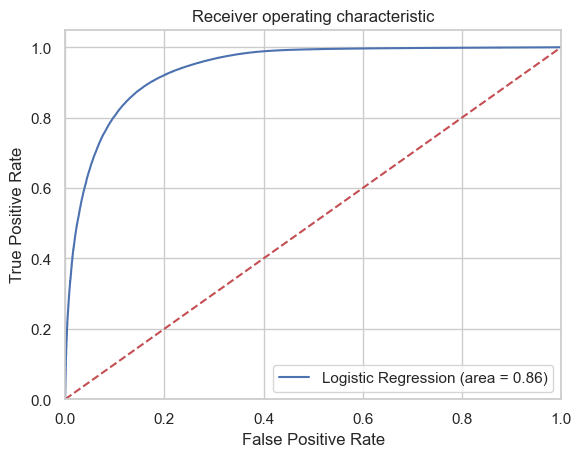

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytt, yhat)
fpr, tpr, thresholds = roc_curve(ytt, yhat_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()